[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/03-structured-outputs-function-calling-tools.ipynb)

# Part 3: Structured Outputs, Function Calling & Native Tools

This section covers three powerful capabilities of the Gemini API: structured outputs for extracting information into defined schemas, function calling for connecting to external tools and APIs, and native tools like Google Search for enhanced capabilities.

In [20]:
from google import genai
from google.genai import types
from pydantic import BaseModel
from typing import List, Optional
import sys
import os
from IPython.display import Image, Markdown

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
else:
    GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY',None)

# Create client with api key
MODEL_ID = "gemini-2.5-flash-preview-05-20"
client = genai.Client(api_key=GEMINI_API_KEY)

## 1. Structured Outputs

Structured outputs allow you to constrain Gemini to respond with JSON in a specific format instead of unstructured text. This is essential for:
- **Data extraction**: Converting unstructured text into structured data
- **API integration**: Getting consistent formats for downstream processing  
- **Database insertion**: Ensuring data matches your schema requirements
- **Quality control**: Validating that responses contain required fields

In [21]:
class Recipe(BaseModel):
    recipe_name: str
    ingredients: List[str]
    prep_time_minutes: int
    difficulty: str  # "easy", "medium", "hard"
    servings: int

class RecipeList(BaseModel):
    recipes: List[Recipe]

# Using Pydantic models for structured output
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Give me 2 popular cookie recipes with ingredients and prep details.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=RecipeList,
    ),
)

# Get structured data directly
recipes: List[Recipe] = response.parsed
for recipe in recipes.recipes:
    print(f"Recipe: {recipe.recipe_name}")
    print(f"Ingredients: {recipe.ingredients}")
    print(f"Prep Time: {recipe.prep_time_minutes} minutes")
    print(f"Difficulty: {recipe.difficulty}")
    print(f"Servings: {recipe.servings}")
    print("\n")

Recipe: Classic Chocolate Chip Cookies
Ingredients: ['1 1/2 cups all-purpose flour', '1/2 teaspoon baking soda', '1/4 teaspoon salt', '1/2 cup unsalted butter, softened', '1/2 cup granulated sugar', '1/2 cup packed light brown sugar', '1 large egg', '1 teaspoon vanilla extract', '1 cup chocolate chips']
Prep Time: 15 minutes
Difficulty: Easy
Servings: 24


Recipe: Chewy Oatmeal Raisin Cookies
Ingredients: ['1 1/4 cups all-purpose flour', '1 teaspoon baking soda', '1 teaspoon ground cinnamon', '1/2 teaspoon salt', '1/2 cup unsalted butter, softened', '3/4 cup packed light brown sugar', '1/4 cup granulated sugar', '1 large egg', '1 teaspoon vanilla extract', '1 1/2 cups rolled oats', '1 cup raisins']
Prep Time: 20 minutes
Difficulty: Medium
Servings: 20




## !! Exercise: PDF to Structured Data !!

Extract structured information from a PDF invoice or document using the Files API and structured outputs.

Tasks:
- A Pydantic schema (`InvoiceItem` and `InvoiceData`) and an example PDF file path (`../assets/data/rewe_invoice.pdf`) are provided. You can use this or replace it with your own PDF invoice.
- Upload the PDF file using `client.files.upload()`.
- Call `client.models.generate_content()`:
- Access the parsed structured data from `response.parsed`.

In [ ]:
class InvoiceItem(BaseModel):
    description: str
    quantity: int
    unit_price: float
    total: float

class InvoiceData(BaseModel):
    invoice_number: str
    date: str
    vendor_name: str
    vendor_address: str
    total_amount: float
    items: List[InvoiceItem]

# Upload a PDF file (replace with your PDF path)
pdf_file_path = "../assets/data/rewe_invoice.pdf"

# TODO:

## 2. Function Calling

Function calling allows Gemini to intelligently decide when to call specific functions you define. This enables:
- **External API integration**: Connect to weather, stocks, databases
- **Dynamic calculations**: Perform real-time computations
- **System interaction**: Execute commands or retrieve system information
- **Multi-step workflows**: Chain function calls for complex tasks

In [ ]:
def get_weather(location: str) -> dict:
    """Gets current weather for a location.

    Args:
        location: The city name, e.g. "San Francisco"

    Returns:
        Weather information dictionary
    """
    # Mock weather data - in real use, you'd call a weather API
    weather_data = {
        "temperature": 22,
        "condition": "sunny",
        "humidity": 60,
        "location": location,
        "feels_like": 24
    }
    print(f"🌤️ FUNCTION CALLED: get_weather(location='{location}')")
    return weather_data

# Define function declarations for the model
weather_function = {
    "name": "get_weather",
    "description": "Gets current weather for a location",
    "parameters": {
        "type": "object",
        "properties": {
            "location": {
                "type": "string",
                "description": "The city name"
            }
        },
        "required": ["location"]
    }
}
tools = [types.Tool(function_declarations=[weather_function])]

# Define user prompt
contents = [
    types.Content(
        role="user", parts=[types.Part(text="Whats the weather in Tokyo?")]
    )
]


# Send request with function declarations
response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

# Check for function calls
function_call = response.candidates[0].content.parts[0].function_call
print(f"Model wants to call: {function_call.name}")
print(f"With arguments: {dict(function_call.args)}")

In [ ]:
# Execute the function
if function_call.name == "get_weather":
    result = get_weather(**function_call.args)
else:
    result = {"error": "Unknown function"}

print(f"Function result: {result}")

# Send function result back to model
function_response_part = types.Part.from_function_response(
    name=function_call.name,
    response={"result": result}
)
# Append function call and result of the function execution to contents
contents.append(types.Content(role="model", parts=[types.Part(function_call=function_call)])) # Append the model's function call message
contents.append(types.Content(role="user", parts=[function_response_part])) # Append the function response

# Get final response
final_response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

print(f"\nFinal response: {final_response.text}")

### Automatic Function Calling (Python Only)

The Python SDK can automatically handle function execution for you:

In [ ]:
def calculate_area(length: float, width: float) -> dict:
    """Calculate the area of a rectangle.

    Args:
        length: Length of the rectangle
        width: Width of the rectangle

    Returns:
        Price calculations
    """
    area = length * width
    print(f"CALC: {length} × {width} = {area}")
    return {"operation": "area", "result": area}

# Using automatic function calling - much simpler!
config = types.GenerateContentConfig(
    tools=[get_weather, calculate_area]  # Pass functions directly
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the weather in Tokyo and what's the area of a 5x3 meter room?",
    config=config
)

print(response.text)  # SDK handles function calls automatically

## !! Exercise: Calculator Agent !!

Create a set of calculator functions (add, subtract, multiply, divide) and use Gemini's function calling capability to perform calculations based on natural language prompts.

Tasks:
- Define Python functions for `add(a: float, b: float)`, `subtract(a: float, b: float)`, `multiply(a: float, b: float)`, and `divide(a: float, b: float)`.
- Create a list of these functions (`calculator_tools`).
- Test single operations with `client.models.generate_content()`:
- Test complex expressions with a prompt for a multi-step calculation (e.g., "Calculate (25 + 15) * 3 - 10. Do this step by step.").

In [ ]:
# TODO:

## 3. Native Tools

Gemini provides native tools for enhanced capabilities like searching the web and analyzing URL content.

### Google Search Integration

**Use cases:**
- Current events and news
- Real-time data lookup
- Fact verification
- Research assistance

In [3]:
# Define Google Search tool
google_search_tool = types.Tool(google_search=types.GoogleSearch())

# Current events query
response = client.models.generate_content(
    model=MODEL_ID,
    contents="What are the latest developments in renewable energy technology in 2025?",
    config=types.GenerateContentConfig(
        tools=[google_search_tool],
    )
)

print("🔍 Current Renewable Energy News:")
print(response)

🔍 Current Renewable Energy News:
In 2025, the renewable energy sector is seeing significant advancements across various technologies, driven by a global push towards sustainability and increased investment. Renewable electricity is projected to surpass coal as the world's leading energy source this year, marking a crucial turning point in addressing climate change.

Key developments and trends in renewable energy technology in 2025 include:

*   **Perovskite Solar Cells** These cells are revolutionizing solar power with notable efficiency gains and increasing affordability. They have advanced from 3% efficiency in 2009 to over 25% today, competing with traditional silicon panels. Tandem solar cells, which combine perovskite and silicon layers, further boost efficiency to over 30%. While stability remains a challenge due to exposure to moisture, oxygen, or heat, solutions like protective encapsulation layers and improved materials are under development, with a focus on scalable producti

In [4]:
print(response)

candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, file_data=None, code_execution_result=None, executable_code=None, function_call=None, function_response=None, text="In 2025, the renewable energy sector is seeing significant advancements across various technologies, driven by a global push towards sustainability and increased investment. Renewable electricity is projected to surpass coal as the world's leading energy source this year, marking a crucial turning point in addressing climate change.\n\nKey developments and trends in renewable energy technology in 2025 include:\n\n*   **Perovskite Solar Cells** These cells are revolutionizing solar power with notable efficiency gains and increasing affordability. They have advanced from 3% efficiency in 2009 to over 25% today, competing with traditional silicon panels. Tandem solar cells, which combine perovskite and silicon layers, further boost efficiency to over 30%. While stability re

### URL Context Tool

**Use cases:**
- Website content analysis
- Documentation summarization
- Competitive research
- Content extraction

In [8]:
# URL context for analyzing specific web pages
url_context_tool = types.Tool(url_context=types.UrlContext())

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Give me a TLDR of what is on https://marginalrevolution.com in 3 bullet points and then a short paragraph.",
    config=types.GenerateContentConfig(
        tools=[url_context_tool],
    )
)

print("TLDR:")
print(response.text)

TLDR:
Here's a TLDR of Marginal Revolution:

*   The blog covers a diverse range of topics, including economics, current events, law, and arts/travel.
*   It frequently features "assorted links" posts, curating news and interesting articles from various sources.
*   Authors Tyler Cowen and Alex Tabarrok provide analysis on economic issues, often discussing new academic research and its real-world implications.

Marginal Revolution is an economics-focused blog run by Tyler Cowen and Alex Tabarrok, featuring daily posts that explore a wide array of subjects beyond economics, such as current affairs, law, and culture. The site frequently summarizes recent academic papers and provides commentary on global economic and political trends, often through curated links and detailed discussions.


In [10]:
!pip install firecrawl-py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 3.5 MB/s eta 0:00:00


In [26]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
import time
from firecrawl import AsyncFirecrawlApp
from google import genai
from google.genai import types
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    FIRECRAWL_API_KEY = userdata.get('FIRECRAWL_API_KEY') # Make sure you add FIRECRAWL_API_KEY to Colab secrets
else:
    GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY', None)
    FIRECRAWL_API_KEY = os.environ.get('FIRECRAWL_API_KEY', None)

# Create client with api key
MODEL_ID = "gemini-2.5-flash-preview-05-20"
client = genai.Client(api_key=GEMINI_API_KEY)

url_to_summarize = 'https://marginalrevolution.com'

# Method 1: Firecrawl + Gemini
print("--- Method 1: Firecrawl + Gemini ---")

async def firecrawl_and_gemini_tldr(url: str, gemini_client):
    app = AsyncFirecrawlApp(api_key=FIRECRAWL_API_KEY)
    start_time = time.time()

    # Step 1: Scrape with Firecrawl
    print(f"Scraping {url} with Firecrawl...")
    try:
        firecrawl_response = await app.scrape_url(
            url=url,
            formats=['markdown'],
            only_main_content=True
        )
    except Exception as e:
        print(f"Firecrawl scraping failed: {e}")
        return None, None, None, None


    # Access the markdown content directly from the response object's markdown attribute
    firecrawl_content = getattr(firecrawl_response, 'markdown', '')

    print(f"Length of firecrawl content: {len(firecrawl_content)}") # Print content length for context

    if not firecrawl_content:
        print("Firecrawl failed to get content.")
        print("Firecrawl Response Object:")
        print(firecrawl_response)
        return None, None, None, None

    # Step 2: Summarize with Gemini
    print("Summarizing content with Gemini...")
    try:
        gemini_response = gemini_client.models.generate_content(
            model=MODEL_ID,
            contents=f"Give me a TLDR of the following markdown content in 3 bullet points and then a short paragraph:\n\n{firecrawl_content}",
        )
        tldr_text = gemini_response.text

        # Extract token usage
        input_tokens = getattr(gemini_response.usage_metadata, 'prompt_token_count', 'N/A')
        output_tokens = getattr(gemini_response.usage_metadata, 'candidates_token_count', 'N/A')

    except Exception as e:
        print(f"Gemini summarization failed: {e}")
        tldr_text = "Summarization failed."
        input_tokens = 'Error'
        output_tokens = 'Error'


    end_time = time.time()
    response_time = end_time - start_time

    return tldr_text, response_time, input_tokens, output_tokens

# Use the existing event loop in the notebook environment with nest_asyncio
loop = asyncio.get_event_loop()
tldr_firecrawl_gemini, time_firecrawl_gemini, input_tokens_fc_gemini, output_tokens_fc_gemini = loop.run_until_complete(firecrawl_and_gemini_tldr(url_to_summarize, client))

if tldr_firecrawl_gemini is not None:
    print("\nTLDR (Firecrawl + Gemini):")
    print(tldr_firecrawl_gemini)
    print(f"Response time: {time_firecrawl_gemini:.2f} seconds")
    print(f"Gemini Token Usage (Firecrawl + Gemini):")
    print(f"  Input Tokens: {input_tokens_fc_gemini}")
    print(f"  Output Tokens: {output_tokens_fc_gemini}")


print("\n" + "="*50 + "\n")

# Method 2: Gemini URL Context Tool
print("--- Method 2: Gemini URL Context ---")

url_context_tool = types.Tool(url_context=types.UrlContext())

start_time = time.time()

try:
    response_gemini_url = client.models.generate_content(
        model=MODEL_ID,
        contents=f"Give me a TLDR of what is on {url_to_summarize} in 3 bullet points and then a short paragraph.",
        config=types.GenerateContentConfig(
            tools=[url_context_tool],
        )
    )
    tldr_gemini_url = response_gemini_url.text

    # Extract token usage
    input_tokens_url_gemini = getattr(response_gemini_url.usage_metadata, 'prompt_token_count', 'N/A')
    output_tokens_url_gemini = getattr(response_gemini_url.usage_metadata, 'candidates_token_count', 'N/A')

except Exception as e:
    print(f"Gemini URL Context failed: {e}")
    tldr_gemini_url = "TLDR generation failed."
    input_tokens_url_gemini = 'Error'
    output_tokens_url_gemini = 'Error'

end_time = time.time()
time_gemini_url = end_time - start_time

print("\nTLDR (Gemini URL Context):")
print(tldr_gemini_url)
print(f"Response time: {time_gemini_url:.2f} seconds")
print(f"Gemini Token Usage (Gemini URL Context):")
print(f"  Input Tokens: {input_tokens_url_gemini}")
print(f"  Output Tokens: {output_tokens_url_gemini}")

--- Method 1: Firecrawl + Gemini ---
Scraping https://marginalrevolution.com with Firecrawl...
Length of firecrawl content: 18689
Summarizing content with Gemini...

TLDR (Firecrawl + Gemini):
Here's a TLDR of the markdown content:

*   A growing trend in Chinese cities involves companies offering "pretend work" spaces for a fee, allowing people to simulate employment, often to hide unemployment from family.
*   The author recounts a challenging personal adventure to a remote, indigenous Mexican village to commission and collect folk art directly from a local painter.
*   The content also highlights various global issues, including concerns over US government debt, a significant increase in Italian emigration, and the complex dynamics of Mexico's democracy.

This compilation covers a range of topics, from a unique social phenomenon in China where individuals pay to simulate employment, to the author's personal tale of intrepid art collecting in a remote Mexican village. It also provide

### Code Execution Tool

Gemini can execute Python code to perform calculations, create visualizations, and process data.

To create the bar chart, I first need the population data for the 5 largest cities in the world. Please note that city population figures can vary significantly based on whether "city" refers to the city proper, urban agglomeration, or metropolitan area, and the year the data was collected.

For this chart, I will use estimated population data for the top 5 urban agglomerations as of recent years (e.g., late 2022 / early 2023 estimates, commonly cited from sources like the UN or Demographia World Urban Areas).

Here's the data I will use:

| City          | Country     | Population (approx.) |
| :------------ | :---------- | :------------------- |
| Tokyo         | Japan       | 37,200,000           |
| Delhi         | India       | 32,900,000           |
| Shanghai      | China       | 29,200,000           |
| Dhaka         | Bangladesh  | 23,200,000           |
| São Paulo     | Brazil      | 22,600,000           |

Now, I will use `matplotlib` to generate the bar chart.



```python
import matplotlib.pyplot as plt
import numpy as np

# Data for the 5 largest cities (approximate urban agglomeration populations)
cities = ['Tokyo', 'Delhi', 'Shanghai', 'Dhaka', 'São Paulo']
populations = [37.2, 32.9, 29.2, 23.2, 22.6] # Populations in millions

# Create a bar chart
plt.figure(figsize=(10, 6)) # Set the figure size for better readability
plt.bar(cities, populations, color='skyblue')

# Add titles and labels
plt.xlabel('City')
plt.ylabel('Population (Millions)')
plt.title('Population of the 5 Largest Urban Agglomerations (Approx. 2023)')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if they are too long
plt.xticks(rotation=45, ha='right')

# Add data labels on top of the bars
for i, pop in enumerate(populations):
    plt.text(i, pop + 0.5, f'{pop:.1f}M', ha='center', va='bottom', fontsize=9)


plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
```

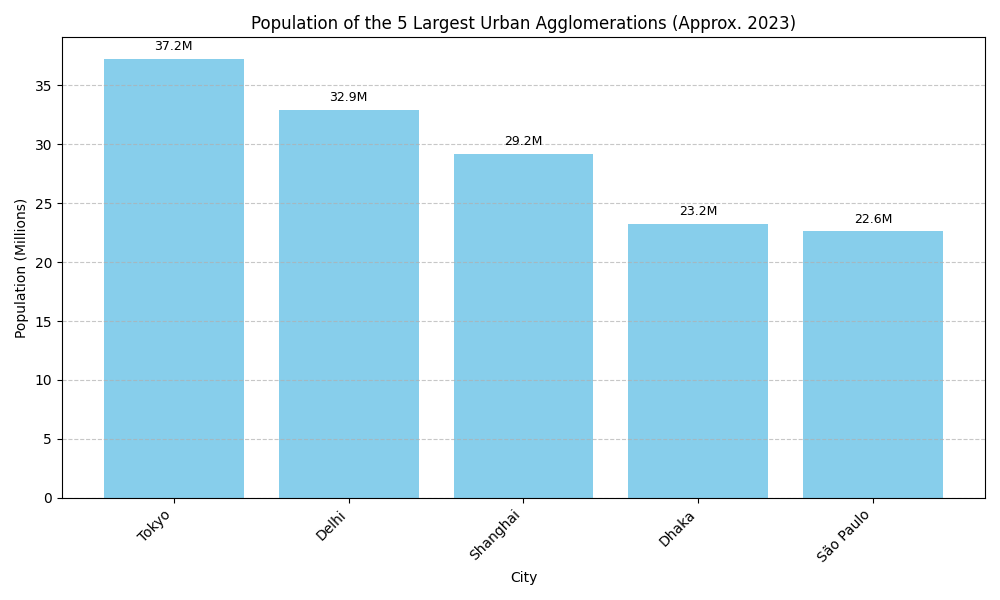

The bar chart titled "Population of the 5 Largest Urban Agglomerations (Approx. 2023)" displays the estimated populations of the five largest urban agglomerations.

Here are the findings from the chart:

*   **Chart Type:** The visualization is a bar chart, which is effective for comparing the magnitudes of different categories.
*   **X-axis:** The x-axis represents the cities: Tokyo, Delhi, Shanghai, Dhaka, and São Paulo. The city names are rotated for better readability.
*   **Y-axis:** The y-axis represents the population in millions, ranging from 0 to 37.5 million, with gridlines at 5-million intervals.
*   **Data Presented:**
    *   **Tokyo:** Has the largest urban agglomeration population, estimated at **37.2 million**.
    *   **Delhi:** Is the second largest, with an estimated population of **32.9 million**.
    *   **Shanghai:** Ranks third, with an estimated population of **29.2 million**.
    *   **Dhaka:** Comes in fourth, with an estimated population of **23.2 million**.
    *   **São Paulo:** Is the fifth largest, with an estimated population of **22.6 million**.
*   **Visual Elements:** Each bar is colored 'skyblue', and data labels showing the exact population in millions (e.g., '37.2M') are placed on top of each bar for easy reference. A horizontal grid further aids in reading the population values.

In [6]:
# Code execution tool
code_execution_tool = types.Tool(code_execution={})

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Create a bar chart showing the population of the 5 largest cities in the world. Use matplotlib.",
    config=types.GenerateContentConfig(
        tools=[code_execution_tool],
    )
)


for p in response.candidates[0].content.parts:
    if p.text:
        display(Markdown(p.text))
    elif p.executable_code:
        display(Markdown(f"```python\n{p.executable_code.code}\n```"))
    elif p.inline_data:
        display(Image(data=p.inline_data.data, width=800, format="png"))


## !! Exercise: Data Analysis with Code Execution !!

Combine Google Search and Code Execution tools to find real-world data and then analyze or visualize it using Python code generated and executed by Gemini.

Tasks:
- Define a prompt that requires both searching for information and then processing/visualizing that information. For example: "Search for the population of the 5 largest cities in the world and create a bar chart of their populations."
- Create a `types.Tool` for code execution: `code_execution_tool = types.Tool(code_execution={})`.
- Create a `types.Tool` for Google Search: `google_search_tool = types.Tool(google_search=types.GoogleSearch())`.
- Call `client.models.generate_content()`:
- Iterate through the `response.candidates[0].content.parts` and display the parts.

In [ ]:
# TODO:

## Recap & Next Steps

**What You've Learned:**
- Structured outputs using Pydantic models for reliable data extraction and validation
- Function calling to integrate external APIs, databases, and custom business logic
- Native tools including Google Search, URL context analysis, and code execution
- Combining multiple tools for comprehensive workflows and complex problem-solving

**Key Takeaways:**
- Structured outputs ensure consistent data formats for downstream applications
- Function calling enables seamless integration with external systems and real-time data
- Native tools provide powerful capabilities without additional setup or infrastructure
- Tool combinations unlock sophisticated workflows and multi-step problem solving
- Proper validation and error handling are crucial for reliable tool interactions

**Next Steps:** Continue with [Part 4: Model Context Protocol (MCP)](https://github.com/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb)

**More Resources:**
- [Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python)
- [Function Calling Documentation](https://ai.google.dev/gemini-api/docs/function-calling?lang=python)
- [Grounding with Google Search](https://ai.google.dev/gemini-api/docs/grounding)
- [URL Context Tool](https://ai.google.dev/gemini-api/docs/url-context)
- [Code Execution Documentation](https://ai.google.dev/gemini-api/docs/code-execution)